# Exploration of the online data
This notebook loads the different online datasets and produces some of the figures from the paper. <br>
The goal of this notebook is to show how to load and explore the online data.

In [1]:
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.transforms
import matplotlib.path
from matplotlib.collections import LineCollection

import numpy
from astropy.io import fits
import pickle
import pandas
from scipy import optimize
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['text.usetex'] = False

Populating the interactive namespace from numpy and matplotlib


In [9]:
def rainbowarrow(ax, start, end, cmap="viridis", n=50,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = numpy.array([x,y]).T.reshape(-1,1,2)
    segments = numpy.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(numpy.linspace(0,1,n))
    ax.add_collection(lc)
    # Arrow head: Triangle
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = numpy.arctan2(end[1]-start[1],end[0]-start[0])
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(end[0],end[1], c=1, s=(4*lw)**2, marker=tri, cmap=cmap,vmin=0)
    ax.autoscale_view()

# 1. Type I AGN sequence
The cells below load and analyze the sequence of type I AGN. <br>
The first cell loads the continuum-subtracted emission line spectra, which are already ordered according to the detected sequence. The emission line spectra are interpolated to a common wavelength grid between 4000 and 7000 A with 1 A resolution. <br>
The second cell loads the metadata of the type I AGN sample we worked with. The objects are already ordered according to the detected sequence, where the plate-mjd-fiber correspond to the SDSS ID of each object, and the rest of the fields are taken from the quasar catalog by Shen et al. (2011).

(3000,) (1941, 3000)


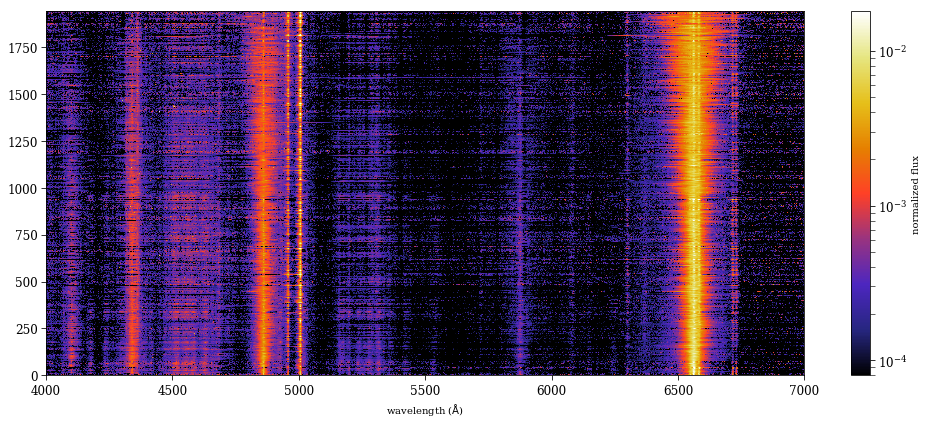

In [5]:
# load the spectra and construct the wavelength range 
# the spectra are already ordered according to the detected sequence 
wavelength = numpy.arange(4000, 7000, 1)
spectra_matrix = numpy.loadtxt("./data/typeI_AGN_spectra.csv", delimiter=",")
print(wavelength.shape, spectra_matrix.shape)

indices_for_plot = numpy.arange(len(spectra_matrix))
X, Y = numpy.meshgrid(wavelength, indices_for_plot)

plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.00008, 0.018), cmap="CMRmap", norm=LogNorm())
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [13]:
# load the metadata for these quasars and plot the correlation of the sequence with various parameters
# the lines in the file are already ordered according to the detected sequence 

path = "./data/typeI_AGN_metadata.csv"
metadata_typeI = pandas.read_csv(path, sep=' *, *')

metadata_typeI

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,plate,mjd,fiber,FWHM_broad_Halpha,log_L_OIII_5007,log_L_narrow_Hbeta,EW_broad_Hbeta,EW_broad_FeII,EW_OIII_5007,r_mag,W1_mag,W2_mag,W3_mag,W4_mag,log_BH_mass,log_L_bol,log_Eddington_ratio
0,540.0,51996.0,549.0,3006.0,41.5,40.18,27.1,23.1,11.7,17.994,12.229,11.247,8.604,6.475,8.84,45.066,-1.88
1,353.0,51703.0,132.0,2037.3,41.5,41.04,16.4,29.5,11.6,18.822,14.276,13.394,10.069,7.706,7.79,45.132,-0.76
2,353.0,51703.0,374.0,1848.0,41.4,41.13,40.8,31.8,8.4,18.765,14.221,13.211,10.111,7.813,7.70,45.123,-0.68
3,529.0,52025.0,195.0,2877.8,41.3,41.11,23.0,15.1,6.1,18.576,14.230,13.433,10.280,7.728,8.03,45.187,-0.95
4,2103.0,53467.0,353.0,2694.9,41.7,41.34,7.5,6.9,11.4,18.491,NaN,NaN,NaN,NaN,9.06,45.325,-1.83
5,1446.0,53080.0,220.0,2884.8,41.4,41.25,8.7,7.8,6.5,18.492,NaN,NaN,NaN,NaN,8.84,45.217,-1.72
6,940.0,52670.0,96.0,2653.5,41.3,40.85,25.6,22.4,9.9,18.699,NaN,NaN,NaN,NaN,8.21,45.010,-1.30
7,2202.0,53566.0,513.0,3350.0,41.4,40.92,19.2,9.8,8.0,18.840,14.206,13.427,10.178,7.851,8.31,45.153,-1.25
8,1822.0,53172.0,551.0,9013.8,41.6,40.74,15.9,17.9,11.7,18.739,14.343,13.647,10.705,8.618,9.09,45.191,-2.00
9,484.0,51907.0,214.0,4785.3,40.9,40.72,13.7,18.3,2.7,18.841,14.079,13.160,10.330,9.229,8.28,45.108,-1.27


In [14]:
metadata_typeI.columns

Index(['plate', 'mjd', 'fiber', 'FWHM_broad_Halpha', 'log_L_OIII_5007',
       'log_L_narrow_Hbeta', 'EW_broad_Hbeta', 'EW_broad_FeII', 'EW_OIII_5007',
       'r_mag', 'W1_mag', 'W2_mag', 'W3_mag', 'W4_mag', 'log_BH_mass',
       'log_L_bol', 'log_Eddington_ratio'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


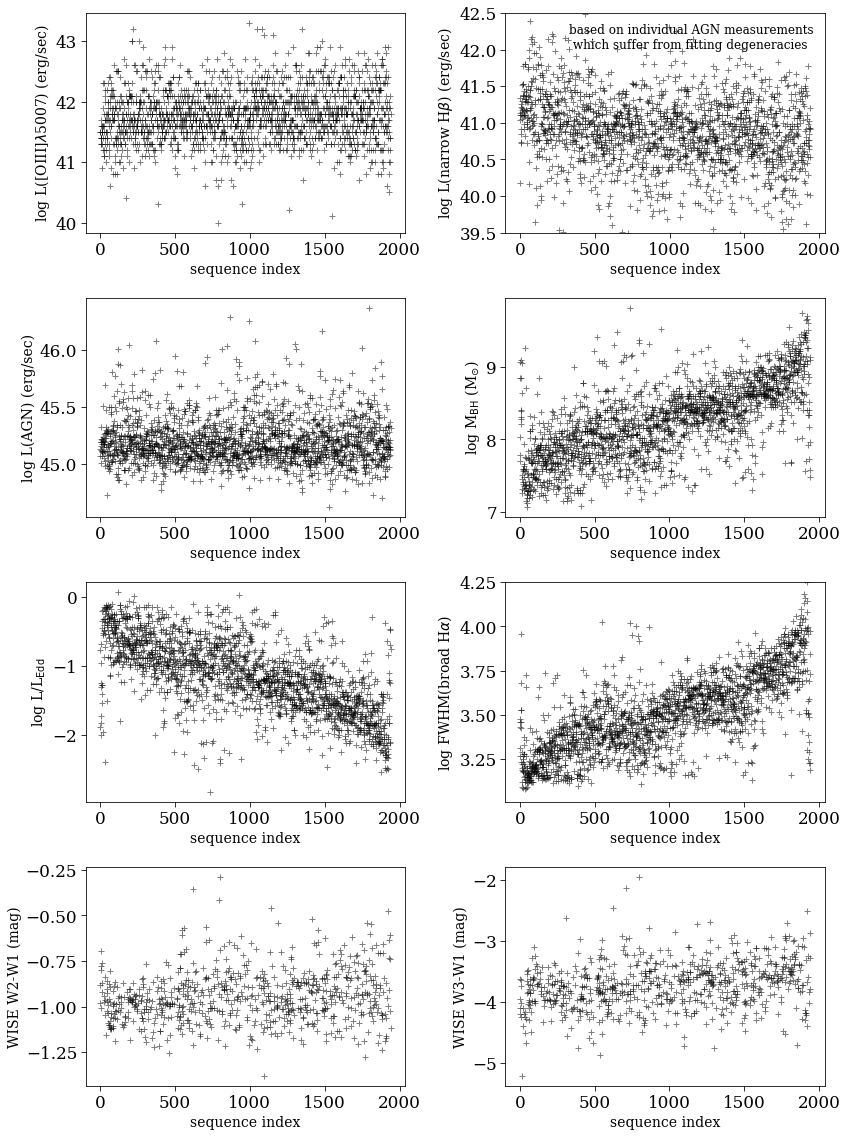

In [17]:
plt.figure(1, figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(metadata_typeI['log_L_OIII_5007'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("log L([OIII]$\\lambda$5007) (erg/sec)")

plt.subplot(4, 2, 2)
plt.plot(metadata_typeI['log_L_narrow_Hbeta'], "+k", alpha=0.5, label="based on individual AGN measurements\n which suffer from fitting degeneracies")
plt.xlabel("sequence index")
plt.ylabel("log L(narrow H$\\beta$) (erg/sec)")
plt.ylim(39.5, 42.5)
plt.legend(loc="best", fontsize=12, frameon=False)

plt.subplot(4, 2, 3)
plt.plot(metadata_typeI['log_L_bol'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("log L(AGN) (erg/sec)")

plt.subplot(4, 2, 4)
plt.plot(metadata_typeI['log_BH_mass'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("log M$_{\\mathrm{BH}}$ (M$_{\\mathrm{\\odot}}$)")

plt.subplot(4, 2, 5)
plt.plot(metadata_typeI['log_Eddington_ratio'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("log L/L$_{\\mathrm{Edd}}$")


plt.subplot(4, 2, 6)
plt.plot(numpy.log10(metadata_typeI['FWHM_broad_Halpha']), "+k", alpha=0.5)
plt.ylim(ymax=4.25)
plt.xlabel("sequence index")
plt.ylabel("log FWHM(broad H$\\alpha$)")

plt.subplot(4, 2, 7)
plt.plot(metadata_typeI['W2_mag'] - metadata_typeI['W1_mag'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("WISE W2-W1 (mag)")

plt.subplot(4, 2, 8)
plt.plot(metadata_typeI['W3_mag'] - metadata_typeI['W1_mag'], "+k", alpha=0.5)
plt.xlabel("sequence index")
plt.ylabel("WISE W3-W1 (mag)")

plt.tight_layout()

# 1.1. Comparison with EV1
The next cells compare the sequence found in this work with the PCA-based Eigenvector 1 (see Boroson \& Green 1992 and Shen \& Ho 2014). The cells use the type I metadata loaded before.

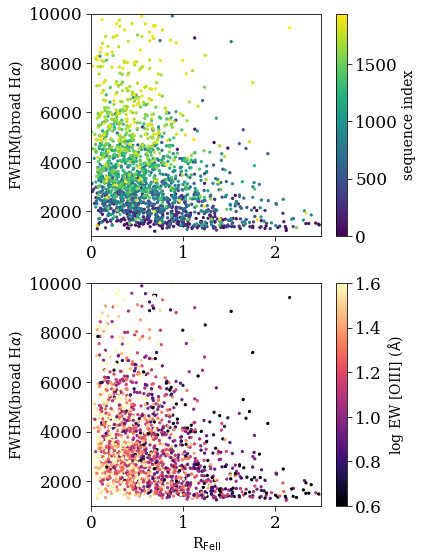

In [23]:
plt.figure(1, figsize = (6, 8))

# define the quantities to plot
R_fe_to_plot = metadata_typeI['EW_broad_FeII'] / metadata_typeI['EW_broad_Hbeta']
fwhm_broad_halpha_to_plot = metadata_typeI['FWHM_broad_Halpha']
log_ew_oiii_to_plot = numpy.log10(metadata_typeI['EW_OIII_5007'])
index_to_plot = numpy.arange(len(metadata_typeI)) # this is the sequence index, the data is already ordered according to it


plt.subplot(2, 1, 1)
plt.scatter(R_fe_to_plot, fwhm_broad_halpha_to_plot, s=5, c=index_to_plot)
plt.colorbar(label="sequence index")
plt.ylim(1000, 10000)
plt.xlim(0, 2.5)
plt.ylabel("FWHM(broad H$\\alpha$)")


plt.subplot(2, 1, 2)
log_ew_oiii_to_plot_clip = numpy.clip(log_ew_oiii_to_plot, 0.6, 1.6)
plt.scatter(R_fe_to_plot, fwhm_broad_halpha_to_plot, s=5, c=log_ew_oiii_to_plot_clip, cmap="magma")
plt.ylim(1000, 10000)
plt.xlim(0, 2.5)
plt.xlabel("R$_{\\mathrm{FeII}}$")
plt.ylabel("FWHM(broad H$\\alpha$)")
plt.colorbar(label="log EW [OIII] ($\\mathrm{\\AA}$)")


plt.subplots_adjust(hspace=0)
plt.tight_layout()

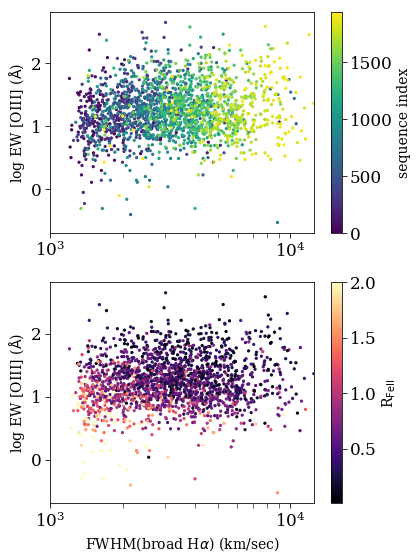

In [24]:
plt.figure(1, figsize = (6, 8))


plt.subplot(2, 1, 1)
plt.scatter(fwhm_broad_halpha_to_plot, log_ew_oiii_to_plot, s=5, c=index_to_plot)
plt.xlim(10**3, 10**4.1)
plt.xscale("log")
plt.ylabel("log EW [OIII] ($\\mathrm{\\AA}$)")
plt.colorbar(label="sequence index")


plt.subplot(2, 1, 2)
R_fe_to_plot_cliped = numpy.clip(R_fe_to_plot, 0, 2)
plt.scatter(fwhm_broad_halpha_to_plot, log_ew_oiii_to_plot, s=5, c=R_fe_to_plot_cliped, cmap="magma")
plt.xlim(10**3, 10**4.1)
plt.xscale("log")
plt.xlabel("FWHM(broad H$\\alpha$) (km/sec)")
plt.ylabel("log EW [OIII] ($\\mathrm{\\AA}$)")
plt.colorbar(label="R$_{\\mathrm{FeII}}$")

plt.tight_layout()

# 1.2. Stacked spectra and the NLR-BLR correlation
The next cell produces 8 stacked spectra using the sequence index, and load the narrow log[OIII]/H$\beta$ versus FWHM(broad H$\alpha$) measurements from the best-fitting emission line decomposition. 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


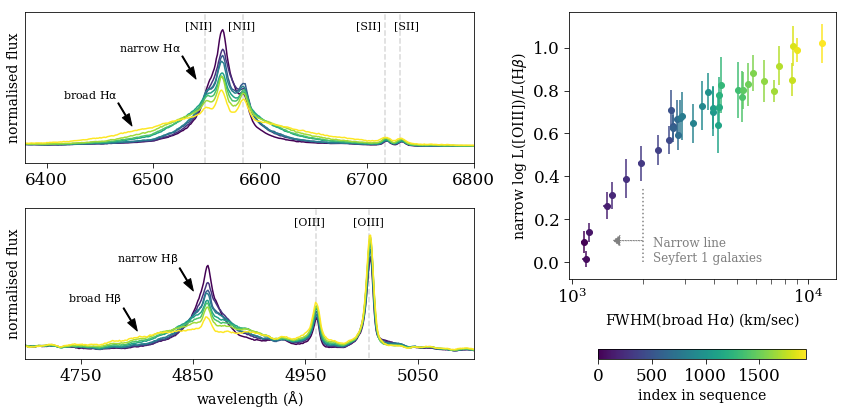

In [31]:
plt.figure(1, figsize = (12, 6))


# stack the spectra according to the sequence index
indices = numpy.arange(len(spectra_matrix))
indices_split = numpy.array_split(indices, 8)

stacked_spectra = []
for ind_list in indices_split:
    spectra_matrix_small = spectra_matrix[ind_list, :]
    spec_median = numpy.median(spectra_matrix_small, axis=0)
    stacked_spectra.append(spec_median)

norm = mpl.colors.Normalize(vmin=0, vmax=7)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

###################################################################################################################
###################################################################################################################

ax1 = plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=1)
for i in range(len(stacked_spectra)):
    plt.plot(wavelength, stacked_spectra[i], color=m.to_rgba(i))

ax = plt.gca()

ax.annotate('[NII]',
            xy=(6530, 0.0105), xycoords='data', fontsize=11) #  -0.0007

ax.annotate('[NII]',
            xy=(6570, 0.0105), xycoords='data', fontsize=11) # 

ax.annotate('[SII]',
            xy=(6700 - 10, 0.0105), xycoords='data', fontsize=11) # -0.00078

ax.annotate('[SII]',
            xy=(6700 + 25, 0.0105), xycoords='data', fontsize=11) # -0.00078

ax.annotate('broad H$\\mathrm{\\alpha}$',
            xy=(6480, 0.0018), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.001, width=1, headwidth=8, frac=1),
            horizontalalignment='right', verticalalignment='bottom', fontsize=11)

ax.annotate('narrow H$\\mathrm{\\alpha}$',
            xy=(6540, 0.006), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.001, width=1, headwidth=8, frac=1),
            horizontalalignment='right', verticalalignment='bottom', fontsize=11)


plt.vlines([6717, 6731, 6548, 6584], -0.0015, 0.012, linestyles="dashed", color="grey", alpha=0.3)
plt.ylabel("normalised flux")
plt.xlim(6380, 6800)
plt.ylim(ymin=-0.0015, ymax=0.012)
plt.yticks(())

###################################################################################################################
###################################################################################################################

ax2 = plt.subplot2grid((2,5), (1,0), colspan=3, rowspan=1)

for i in range(len(stacked_spectra)):
    plt.plot(wavelength, stacked_spectra[i], color=m.to_rgba(i))
    
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.ylabel("normalised flux")
ax = plt.gca()
ax.annotate('[OIII]',
            xy=(4992, 0.0053), xycoords='data', fontsize=11)
ax.annotate('[OIII]',
            xy=(4940, 0.0053), xycoords='data', fontsize=11) 

ax.annotate('broad H$\\mathrm{\\beta}$',
            xy=(4800, 0.0008), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.001, width=1, headwidth=8, frac=1),
            horizontalalignment='right', verticalalignment='bottom', fontsize=11)

ax.annotate('narrow H$\\mathrm{\\beta}$',
            xy=(4850, 0.0025), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.001, width=1, headwidth=8, frac=1),
            horizontalalignment='right', verticalalignment='bottom', fontsize=11)

plt.vlines([4959, 5007], -0.0007, 0.006, linestyles="dashed", color="grey", alpha=0.3)
plt.xlim(4700, 5100)
plt.ylim(ymin=-0.0004, ymax=0.006,)
plt.xticks((4750, 4850, 4950, 5050))
plt.yticks(())

###################################################################################################################
###################################################################################################################

ax3 = plt.subplot2grid((2,5), (0,3), colspan=2, rowspan=2)

bins_data = pandas.read_csv("./data/typeI_AGN_stacked_measurements.csv", sep=' *, *')

x_list = numpy.array(bins_data['fwhm_broad_halpha']).astype(numpy.float64)
y_list = numpy.array(bins_data['log_oiii_hbeta']).astype(numpy.float64)
x_err_list = numpy.array(bins_data['fwhm_broad_halpha_err']).astype(numpy.float64)#numpy.array(bins_30_data['log_oiii_hbeta']).astype(numpy.float64)
y_err_list = numpy.array(bins_data['log_oiii_hbeta_err']).astype(numpy.float64)
indices_list = numpy.arange(len(x_list))

norm = mpl.colors.Normalize(vmin=0, vmax=indices_list[-1])
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# you need to sort the objects according to their FWHM value
x_list_sorted = numpy.sort(x_list)
y_list_sorted = y_list[numpy.argsort(x_list)]
x_err_list_sorted = x_err_list[numpy.argsort(x_list)]
y_err_list_sorted = y_err_list[numpy.argsort(x_list)]

for i in range(len(x_list)):
    plt.errorbar([x_list_sorted[i]], 
                 [y_list_sorted[i]], 
                 xerr=[x_err_list_sorted[i]], 
                 yerr=[y_err_list_sorted[i]], fmt="o", color=m.to_rgba(i))

plt.vlines(2000, 0, 0.35, color="grey", linestyles='dotted')
ax = plt.gca()
ax.annotate('Narrow line \nSeyfert 1 galaxies',
            xy=(2200, 0.0), xycoords='data', fontsize=12, color="grey")
ax.arrow(2000, 0.1, -400, 0, head_width=0.05, head_length=100, fc='grey', ec='grey', linestyle="dotted")


plt.xscale("log")
plt.xticks((10**3, 10**4))
plt.xlabel("FWHM(broad H$\\mathrm{\\alpha}$) (km/sec)")
plt.ylabel("narrow log L([OIII])/L(H$\\beta$)")

# finally, set a colorbar 
norm = mpl.colors.Normalize(vmin=0, vmax=1940)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(numpy.linspace(0, 1940, 5000))
plt.colorbar(m, orientation="horizontal", label="index in sequence", 
             ticks=[0, 500, 1000, 1500], pad=0.2, fraction=0.03)

plt.tight_layout()

# 2. Type II AGN sample
The next cells load the metadata of the type II AGN sample and plot the resulting black hole - host galaxy scaling relations. <br>
The metadata file consists of infromation from the SDSS, such as plate, mjd, fiber, z, and emission line fluxes and uncertainties. Then, the metadata file lists stellar velocity dispersion measurements and black hole mass estimates (see paper for details). Finally, the file lists various properties extracted from Simard et al. (2011) and Mendel et al. (2014). 

In [3]:
path = "./data/typeII_AGN_metadata.csv"
metadata_typeII = pandas.read_csv(path, sep=' *, *')

metadata_typeII

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,index,plate,mjd,fiberid,z,h_beta_flux,h_beta_flux_err,oiii_5007_flux,oiii_5007_flux_err,h_alpha_flux,...,simard_Rchl_g,simard_Rchl_r,simard_Re,simard_e_Re,simard_e,simard_e_e,simard_nb,simard_e_nb,simard_PpS,simard_Pn4
0,0,266,51630,147,0.030694,58.524400,4.004864,594.88900,7.784786,307.65060,...,3.49,3.35,2.94,0.01,0.46,0.02,4.01,0.59,0.00,0.41
1,1,266,51630,158,0.036445,36.188320,2.318291,114.14670,3.213430,145.37080,...,3.78,3.78,1.69,0.01,0.34,0.09,0.78,0.01,0.78,0.49
2,2,266,51630,216,0.067470,122.330400,5.087923,966.63170,9.964752,472.36780,...,2.42,2.31,1.56,0.91,0.57,0.17,6.25,0.65,0.01,0.26
3,3,266,51630,264,0.148869,18.909600,3.879416,75.69289,3.566085,80.82387,...,6.59,5.83,4.67,0.45,0.39,0.04,1.69,0.39,0.54,0.46
4,4,266,51630,392,0.122263,121.331300,3.905878,452.44900,5.716667,576.23690,...,5.00,4.81,3.82,0.29,0.70,0.01,1.74,0.74,0.15,0.38
5,5,266,51630,422,0.026687,12.107920,2.921700,57.39756,3.946375,50.17290,...,1.40,1.38,0.72,0.00,0.38,0.03,5.64,0.02,0.00,0.35
6,6,266,51630,457,0.123910,29.457220,4.218459,215.31230,4.913185,147.94040,...,3.38,3.35,2.58,0.21,0.33,0.04,4.07,0.24,0.50,0.49
7,7,266,51630,468,0.122092,47.876050,3.846734,173.41870,4.731881,190.73500,...,3.08,3.14,2.15,0.29,0.46,0.05,6.48,0.63,0.47,0.46
8,8,266,51630,600,0.062377,76.619450,3.449817,524.86090,6.523363,244.75730,...,1.05,1.07,1.23,0.14,0.53,0.03,5.29,0.13,0.46,0.47
9,9,267,51608,86,0.137242,17.370770,3.080750,98.33616,4.087401,96.90291,...,7.37,6.53,4.68,0.26,0.65,0.02,1.40,0.12,0.31,0.34


In [4]:
metadata_typeII.columns

Index(['index', 'plate', 'mjd', 'fiberid', 'z', 'h_beta_flux',
       'h_beta_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_alpha_flux', 'h_alpha_flux_err', 'nii_6584_flux',
       'nii_6584_flux_err', 'log_stellar_sigma', 'log_bh_mass', 'objid',
       'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i',
       'psfMagErr_z', 'mendel_logM_p50', 'mendel_logM_p16', 'mendel_logM_p84',
       'mendel_logMt_p50', 'mendel_logMt_p16', 'mendel_logMt_p84',
       'mendel_logMb_p50', 'mendel_logMb_p16', 'mendel_logMb_p84',
       'mendel_logMd_p50', 'mendel_logMd_p16', 'mendel_logMd_p84',
       'simard_b_t_g', 'simard_e_b_t_g', 'simard_b_t_r', 'simard_e_b_t_r',
       'simard_Rhlg', 'simard_Rhlr', 'simard_Rchl_g', 'simard_Rchl_r',
       'simard_Re', 'simard_e_Re', 'simard_e', 'simard_e_e', 'simard_nb',
       'simard_e_nb', 'simard_PpS', 'simard_Pn4'],
      dtype='object')

The next cells contain the functions that are used to find the best-fitting linear relation of the black hole - host galaxy scaling relation. The method is described in the paper.

In [9]:
# something is wrong with my calculation of the errors. I will try to use scipy instead, and we will see if it works!

from scipy.optimize import minimize

def return_minus_log_likelihood(parameters, y_vec, sigma_y, mu_x, sigma_x):
    """
    function returns the log likelihood given the input parameters
    see the paper for additional details
    """
    a = parameters[0]
    b = parameters[1]
    
    A = 1.0/(2.0 * sigma_x**2) + (a**2)/(2.0 * sigma_y**2)
    B = mu_x/(sigma_x**2) + (y_vec*a)/(sigma_y**2) - (a*b)/(sigma_y**2)
    C = - (mu_x**2)/(2.0 * sigma_x**2) - (y_vec**2)/(2.0*sigma_y**2) + (y_vec*b)/(sigma_y**2) - (b**2)/(2.0*sigma_y**2)
    
    L_vec = - 0.5 * numpy.log(A) + (B**2)/(4.0 * A) + C
    L = numpy.sum(L_vec)
    
    return -1.0 * L

def optimize_likelihood_with_scipy(x_vec, y_vec, sigma_y, a_0, b_0):
    """
    function optimizes the likelihood with the scipy functions. 
    """
    mu_x = numpy.median(x_vec)
    sigma_x = numpy.std(x_vec)
    parameters_in = [a_0, b_0]
    
    out = minimize(return_minus_log_likelihood, parameters_in, 
                   args=(y_vec, sigma_y, mu_x, sigma_x))
    
    
    parameters_out = out.x
    success = out.success
    var = out.hess_inv
    
    return parameters_out, success, var

def return_best_fit_and_sigma_lines(x_total, y_total, x_bins, sigma_y, a_0, b_0):
    """
    function returns the best-fitting line we obtain using the MLE, and the sigma around this line
    x_bins = numpy.linspace(1.7, 2.4, 16) for stellar velocity dispersion
    
    """
    pars_out, success, cov_matrix = optimize_likelihood_with_scipy(x_total, y_total, sigma_y, a_0, b_0)
    
    y_predicted = pars_out[0] * x_total + pars_out[1]
    residuals = y_total - y_predicted
    
    x_values = []
    sigma_values = []
    for i in range(len(x_bins)-1):
        x_min = x_bins[i]
        x_max = x_bins[i+1]
        
        residuals_in_range = residuals[(x_total >= x_min) & (x_total < x_max)]
        med_val = numpy.median(residuals_in_range)
        mad_val = numpy.std(residuals_in_range) #numpy.median(numpy.abs(residuals_in_range - med_val))
        sigma_values.append(mad_val)
        
        x_in_range = x_total[(x_total >= x_min) & (x_total < x_max)]
        x_values.append(numpy.median(x_in_range))
        
    sigma_values = numpy.array(sigma_values)
    x_values = numpy.array(x_values)
    
    # collect all the things that you need to return to the main ploting function
    return pars_out[0], pars_out[1], x_values, sigma_values

In [10]:
def return_greene_ho_new_masses():
    """
    function returns the black hole masses and stellar velocity dispersions measured by Greene & Ho (2007)
    note that their BH mass estimates are based on a virial factor of spherical BLR and on older R-L relation
    the main function corrects the measurements to be consistent with the assumptions made in this study.
    """
    path= "./data/greene_ho_msigma.fit"
    h = fits.open(path)
    data_gh = h[1].data
    data_gh

    gh_fwhm = data_gh['FWHM']
    gh_log_lum = data_gh['logL']
    log_mbh_gh_new = 0.031 + 6.57 + 0.47 * (gh_log_lum - 42) + 2.06 * numpy.log10(gh_fwhm/1000.0)
    log_sigma_gh = numpy.log10(data_gh['sigma_'])
    
    x = numpy.copy(log_sigma_gh)
    y = numpy.copy(data_gh['logM'])
    
    return x[~numpy.isnan(x) & ~numpy.isnan(y)], y[~numpy.isnan(x) & ~numpy.isnan(y)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


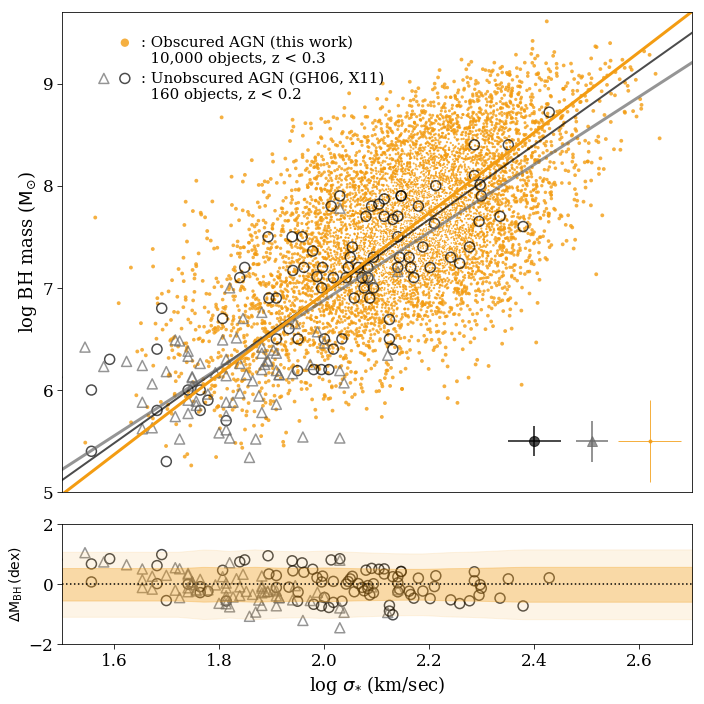

In [11]:
# plot the black hole mass - stellar velocity dispersion relation. Find the best fit and compare the relation 
# to that found in type I AGN studies.

plt.figure(1, figsize=(10, 10))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
plt.subplot(gs[0])

# Give the points sizes which correspond to the density of points around them
x_total = numpy.array(metadata_typeII['log_stellar_sigma']).astype(numpy.float64)
y_total = numpy.array(metadata_typeII['log_bh_mass']).astype(numpy.float64)

x_list = x_total[~numpy.isnan(x_total) & ~numpy.isnan(y_total)]
y_list = y_total[~numpy.isnan(x_total) & ~numpy.isnan(y_total)]

number_of_neighbours = []
for i in range(len(x_list)):
    x_val = x_list[i]
    y_val = y_list[i]
    
    x_in_range = x_list[(x_val - 0.05 <= x_list) & (x_val + 0.05 >= x_list) & (y_val - 0.2 <= y_list) & (y_val + 0.2 >= y_list)]
    len_in_range = len(x_in_range)
    number_of_neighbours.append(len_in_range)
    
number_of_neighbours = numpy.array(number_of_neighbours)
original_indices = numpy.arange(len(number_of_neighbours))
ordered_indices = numpy.argsort(number_of_neighbours)
sizes_array = numpy.logspace(numpy.log10(2), numpy.log10(15), len(number_of_neighbours))[::-1]
sizes_to_plot = numpy.zeros(len(number_of_neighbours))

for i, index_val in enumerate(ordered_indices):
    size_val = sizes_array[i]
    sizes_to_plot[index_val] = size_val


# plot our dataset
plt.scatter(metadata_typeII['log_stellar_sigma'], metadata_typeII['log_bh_mass'], c="#F39C12", s=sizes_to_plot, alpha=0.8, zorder=1, label="this work, obscured AGN", edgecolors='none') 

################################################################################
# plot the other points from other studies
# load Greene and Ho 2016 data, correct to be consistent with our assumptions
log_sigma_gh, log_bh_mass_gh = return_greene_ho_new_masses()
plt.scatter(log_sigma_gh, log_bh_mass_gh + 0.2, s=100, color="k", alpha=0.7, lw=1.5, facecolors='none', label="unobscured AGN, GH06") # I'm adding 0.2 dex to account for the new relations #696969
# Xiao et al data, correct to be consistent with our assumptions
log_sigma_x = numpy.log10([76.0, 57.0, 55.0, 53.0, 38.0, 70.0, 63.0, 107.0, 76.0, 53.0, 50.0, 75.0, 107.0, 42.0, 71.0, 65.0, 65.0, 55.0, 69.0, 107.0, 60.0, 45.0, 72.0, 100.0, 52.0, 35.0, 56.0, 82.0, 76.0, 76.0, 55.0, 55.0, 78.0, 91.0, 109.0, 45.0, 123.0, 77.0, 69.0, 87.0, 97.0, 31.0, 47.0, 62.0, 81.0, 45.0, 56.0, 66.0, 74.0, 65.0, 82.0, 81.0, 47.0, 57.0, 73.0, 64.0, 138.0, 132.0, 78.0, 65.0, 94.0, 52.0, 66.0, 81.0, 67.0, 58.0, 88.0, 68.0, 65.0, 76.0, 56.0, 80.0])
log_bh_mass_x = numpy.array([6.0, 5.69, 6.13, 6.28, 6.03, 6.5, 5.38, 5.99, 6.16, 5.32, 5.98, 5.74, 7.58, 6.08, 5.95, 5.94, 5.55, 5.7, 6.06, 5.33, 5.76, 5.42, 5.14, 6.26, 6.29, 6.22, 5.84, 5.95, 6.22, 5.58, 6.18, 5.57, 6.09, 5.34, 5.87, 5.68, 6.89, 6.05, 5.77, 5.96, 6.37, 5.97, 5.43, 5.97, 5.99, 6.04, 5.93, 6.8, 5.32, 5.41, 5.95, 5.66, 5.86, 5.65, 5.89, 6.29, 6.96, 6.14, 6.08, 5.68, 6.05, 5.54, 5.33, 6.16, 5.68, 6.06, 6.45, 6.31, 6.1, 6.56, 5.92, 6.19])
plt.scatter(log_sigma_x, log_bh_mass_x + 0.2, s=100, marker='^', lw=1.5, color="#696969", alpha=0.7, facecolors='none', label="unobscured AGN, X11") # I'm adding 0.2 dex to account for the new relations

################################################################################
# plot the best-fitting relations from type 1 AGN
sigma_arr = numpy.linspace(1.4, 10**2.8, 50)

log_bh_mass_greene_and_ho = 7.84 + 3.65 * numpy.log10(sigma_arr/ 200.0)
plt.plot(numpy.log10(sigma_arr), log_bh_mass_greene_and_ho + 0.2, "k", lw=2, alpha=0.7) # I'm adding 0.2 dex to account for the new relations

log_bh_mass_xiao = 7.68 + 3.32 * numpy.log10(sigma_arr/200.0)
plt.plot(numpy.log10(sigma_arr), log_bh_mass_xiao + 0.2, "#696969", lw=3, alpha=0.7) # # I'm adding 0.2 dex to account for the new relations

################################################################################
# our best fit 
x_bins = numpy.linspace(1.7, 2.4, 16)
sigma_y = 0.3
a_0 = 3.0
b_0 = 1.0
a, b, x_bins, sigma_bins = return_best_fit_and_sigma_lines(x_list, y_list, x_bins, sigma_y, a_0, b_0)

x_arr = numpy.linspace(1.5, 2.7, 50)
best_fit_our = a * x_arr + b
sigma_interp = numpy.interp(x_arr, x_bins, sigma_bins)
plt.plot(x_arr, best_fit_our, color="#F39C12", lw=3, label="obscured AGN, best fit")

################################################################################
# errorbars 
plt.errorbar([2.62], [5.5], xerr=[0.06], yerr=[0.4], fmt=".", color="#F39C12", alpha=0.8, lw=1) # #F39C12
plt.errorbar([2.4], [5.5], xerr=[0.05], yerr=[0.15], fmt="o", color="k", lw=2, alpha=0.7, markersize=10)
plt.errorbar([2.51], [5.5], xerr=[0.03], yerr=[0.2], fmt="^", color="#696969", lw=2, alpha=0.7, markersize=10)

################################################################################
# legend 
plt.scatter([1.62], [8.85 + 0.2], s=100, color="k", alpha=0.7, lw=1.5, facecolors='none') 
plt.scatter([1.58], [8.85 + 0.2], s=100, marker='^', lw=1.5, color="#696969", alpha=0.7, facecolors='none') # I'm adding 0.2 dex to account for the new relations
ax = plt.gca()
ax.annotate(': Unobscured AGN (GH06, X11)\n  160 objects, z < 0.2',
            xy=(1.65, 8.7 - 0.05 + 0.2), xycoords='data', fontsize=15)

plt.scatter([1.62], [9.2 + 0.2], c="#F39C12", s=70, alpha=0.8, edgecolors='none') 
ax.annotate(': Obscured AGN (this work)\n  10,000 objects, z < 0.3',
            xy=(1.65, 9.05 - 0.05 + 0.2), xycoords='data', fontsize=15)


plt.ylabel("log BH mass ($\\mathrm{M_{\\odot}}$)", fontsize=18)
plt.xlim(1.5, 2.7)
plt.ylim(5.0, 9.7)
ax = plt.gca()
ax.set_xticks(())
plt.tight_layout()


################################################################################
# second panel
plt.subplot(gs[1])

################################################################################
# our measurements
bh_mass_mine = (metadata_typeII['log_bh_mass']).astype(numpy.float64)
sigma_mine = (metadata_typeII['log_stellar_sigma']).astype(float64)
delta_bh_mass_mine = bh_mass_mine - (a * sigma_mine + b)

################################################################################
# Greene and Ho measurements
path= "./data/greene_ho_msigma.fit"
h = fits.open(path)
data_gh = h[1].data
data_gh
log_sigma_gh = numpy.log10(data_gh['sigma_'])
log_bh_mass_gh = data_gh['logM']
delta_bh_mass_gh = log_bh_mass_gh + 0.2 - (7.84 + 0.2 + 3.65 * numpy.log10(10**log_sigma_gh/ 200.0))

################################################################################
# Xiao et al measurements
log_sigma_x = numpy.log10([76.0, 57.0, 55.0, 53.0, 38.0, 70.0, 63.0, 107.0, 76.0, 53.0, 50.0, 75.0, 107.0, 42.0, 71.0, 65.0, 65.0, 55.0, 69.0, 107.0, 60.0, 45.0, 72.0, 100.0, 52.0, 35.0, 56.0, 82.0, 76.0, 76.0, 55.0, 55.0, 78.0, 91.0, 109.0, 45.0, 123.0, 77.0, 69.0, 87.0, 97.0, 31.0, 47.0, 62.0, 81.0, 45.0, 56.0, 66.0, 74.0, 65.0, 82.0, 81.0, 47.0, 57.0, 73.0, 64.0, 138.0, 132.0, 78.0, 65.0, 94.0, 52.0, 66.0, 81.0, 67.0, 58.0, 88.0, 68.0, 65.0, 76.0, 56.0, 80.0])
log_bh_mass_x = numpy.array([6.0, 5.69, 6.13, 6.28, 6.03, 6.5, 5.38, 5.99, 6.16, 5.32, 5.98, 5.74, 7.58, 6.08, 5.95, 5.94, 5.55, 5.7, 6.06, 5.33, 5.76, 5.42, 5.14, 6.26, 6.29, 6.22, 5.84, 5.95, 6.22, 5.58, 6.18, 5.57, 6.09, 5.34, 5.87, 5.68, 6.89, 6.05, 5.77, 5.96, 6.37, 5.97, 5.43, 5.97, 5.99, 6.04, 5.93, 6.8, 5.32, 5.41, 5.95, 5.66, 5.86, 5.65, 5.89, 6.29, 6.96, 6.14, 6.08, 5.68, 6.05, 5.54, 5.33, 6.16, 5.68, 6.06, 6.45, 6.31, 6.1, 6.56, 5.92, 6.19])
delta_bh_mass_xiao = log_bh_mass_x + 0.2 - (7.68 + 0.2 + 3.32 * numpy.log10(10**log_sigma_x/ 200.0))

################################################################################
plt.scatter(log_sigma_gh, delta_bh_mass_gh, s=100, color="k", alpha=0.7, lw=1.5, facecolors='none')
plt.scatter(log_sigma_x, delta_bh_mass_xiao, s=100, marker='^', lw=1.5, color="#696969", alpha=0.7, facecolors='none')

plt.fill_between(x_arr, y1=-2*sigma_interp, y2=2*sigma_interp, color="#F39C12", alpha=0.1) # #F47DC9
plt.fill_between(x_arr, y1=(-sigma_interp), y2=(sigma_interp), color="#F39C12", alpha=0.3) # 

plt.hlines([0], 1.5, 2.7, "k", linestyles="dotted")
plt.xlabel("log $\\sigma_{*}$ (km/sec)", fontsize=18)
plt.ylabel("$\\mathrm{\\Delta M_{BH}\\, (dex)}$")
plt.xlim(1.5, 2.7)
plt.ylim(-2, 2)

plt.tight_layout()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


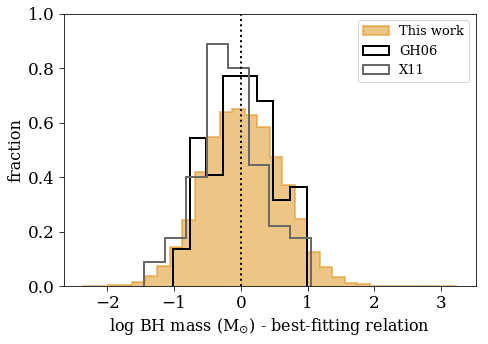

In [12]:
# plot the distribution of residuals around the best-fitting relations

plt.figure(1, figsize = (7, 5))

# our measurements
bh_mass_mine = (metadata_typeII['log_bh_mass']).astype(numpy.float64)
sigma_mine = (metadata_typeII['log_stellar_sigma']).astype(float64)
delta_bh_mass_mine = bh_mass_mine - (a * sigma_mine + b)

# Greene and Ho measurements
# the various +0.2 are there to shift their assumptions to be consistent with ours
path= "./data/greene_ho_msigma.fit"
h = fits.open(path)
data_gh = h[1].data
data_gh
log_sigma_gh = numpy.log10(data_gh['sigma_'])
log_bh_mass_gh = data_gh['logM']
delta_bh_mass_gh = log_bh_mass_gh + 0.2 - (7.84 + 0.2 + 3.65 * numpy.log10(10**log_sigma_gh/ 200.0))

# Xiao et al measurements
# the various +0.2 are there to shift their assumptions to be consistent with ours
log_sigma_x = numpy.log10([76.0, 57.0, 55.0, 53.0, 38.0, 70.0, 63.0, 107.0, 76.0, 53.0, 50.0, 75.0, 107.0, 42.0, 71.0, 65.0, 65.0, 55.0, 69.0, 107.0, 60.0, 45.0, 72.0, 100.0, 52.0, 35.0, 56.0, 82.0, 76.0, 76.0, 55.0, 55.0, 78.0, 91.0, 109.0, 45.0, 123.0, 77.0, 69.0, 87.0, 97.0, 31.0, 47.0, 62.0, 81.0, 45.0, 56.0, 66.0, 74.0, 65.0, 82.0, 81.0, 47.0, 57.0, 73.0, 64.0, 138.0, 132.0, 78.0, 65.0, 94.0, 52.0, 66.0, 81.0, 67.0, 58.0, 88.0, 68.0, 65.0, 76.0, 56.0, 80.0])
log_bh_mass_x = numpy.array([6.0, 5.69, 6.13, 6.28, 6.03, 6.5, 5.38, 5.99, 6.16, 5.32, 5.98, 5.74, 7.58, 6.08, 5.95, 5.94, 5.55, 5.7, 6.06, 5.33, 5.76, 5.42, 5.14, 6.26, 6.29, 6.22, 5.84, 5.95, 6.22, 5.58, 6.18, 5.57, 6.09, 5.34, 5.87, 5.68, 6.89, 6.05, 5.77, 5.96, 6.37, 5.97, 5.43, 5.97, 5.99, 6.04, 5.93, 6.8, 5.32, 5.41, 5.95, 5.66, 5.86, 5.65, 5.89, 6.29, 6.96, 6.14, 6.08, 5.68, 6.05, 5.54, 5.33, 6.16, 5.68, 6.06, 6.45, 6.31, 6.1, 6.56, 5.92, 6.19])
delta_bh_mass_xiao = log_bh_mass_x + 0.2 - (7.68 + 0.2 + 3.32 * numpy.log10(10**log_sigma_x/ 200.0))

# plot the distributions
tmp = plt.hist(delta_bh_mass_mine, bins=30, color="#DD8E0C", alpha=0.5, normed=1, lw=2, histtype='step', fill=True, label="This work")
tmp = plt.hist(delta_bh_mass_gh, bins=8, color="k", normed=1, lw=2, histtype='step', fill=False, label="GH06")
tmp = plt.hist(delta_bh_mass_xiao, bins=8, color="#696969", normed=1, lw=2, histtype='step', fill=False, label="X11")

plt.vlines([0], 0, 1., linestyles="dotted", lw=2, color="k")
plt.legend(loc="upper right", fontsize=13)
plt.ylabel("fraction", fontsize=16)
plt.xlabel("log BH mass (M$_{\\mathrm{\\odot}}$) - best-fitting relation", fontsize=16)
plt.ylim(0, 1.)
plt.tight_layout()

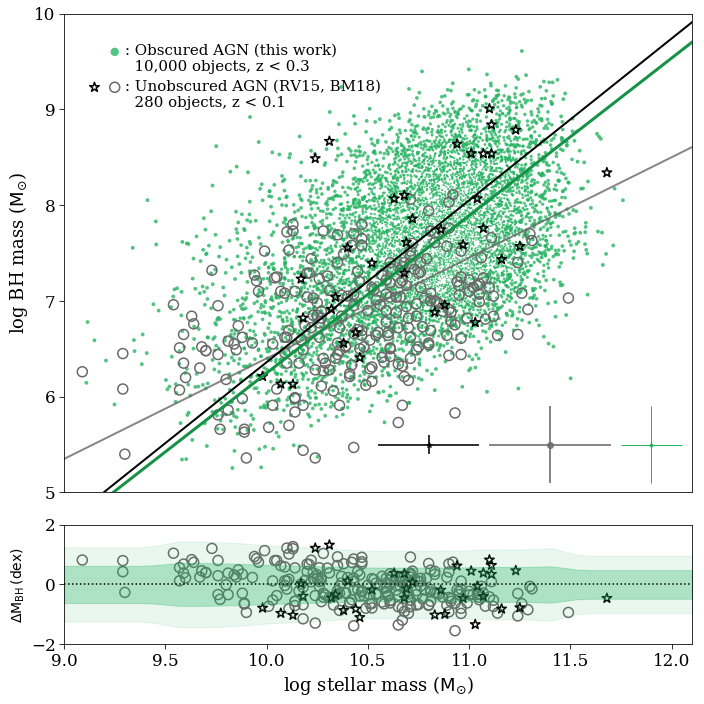

In [14]:
# plot the black hole mass - total stellar mass relation. Find the best fit and compare the relation 
# to that found in type I AGN studies.

plt.figure(1, figsize = (10, 10))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
plt.subplot(gs[0])

x = numpy.array(metadata_typeII['mendel_logMt_p50']).astype(numpy.float64)
y = numpy.array(metadata_typeII['log_bh_mass']).astype(numpy.float64)

x_total = x[~numpy.isnan(x) & ~numpy.isnan(y)]
y_total = y[~numpy.isnan(x) & ~numpy.isnan(y)]

x_list = x_total[(x_total >= 8.5) & (x_total <= 12)]
y_list = y_total[(x_total >= 8.5) & (x_total <= 12)]

number_of_neighbours = []
for i in range(len(x_list)):
    x_val = x_list[i]
    y_val = y_list[i]
    
    x_in_range = x_list[(x_val - 0.05 <= x_list) & (x_val + 0.05 >= x_list) & (y_val - 0.2 <= y_list) & (y_val + 0.2 >= y_list)]
    len_in_range = len(x_in_range)
    number_of_neighbours.append(len_in_range)
    
number_of_neighbours = numpy.array(number_of_neighbours)
original_indices = numpy.arange(len(number_of_neighbours))
ordered_indices = numpy.argsort(number_of_neighbours)
sizes_array = numpy.logspace(numpy.log10(2), numpy.log10(15), len(number_of_neighbours))[::-1]
sizes_to_plot = numpy.zeros(len(number_of_neighbours))

for i, index_val in enumerate(ordered_indices):
    size_val = sizes_array[i]
    sizes_to_plot[index_val] = size_val

################################################################################
# plot our dataset
plt.scatter(x_list, y_list, c="#28B463", s=sizes_to_plot, alpha=0.8, zorder=1, edgecolors='none') 

################################################################################
# other studies
# Reines and Volonetri 2015
path = "./data/reines_volonteri_m_sigma.fit"
h = fits.open(path)
data_reines = h[1].data
bh_mass_reines = data_reines['logMBH']
bulge_mass_reines = data_reines['logM_']
plt.scatter(bulge_mass_reines, bh_mass_reines, s=100, color="#696969", alpha=1, lw=1.5, facecolors='none')

# Bentz and Manne-Nicholas 2018 - I'm ploting the stellar masses that are based on the Bell & de Jong (2001) M/L ratios
log_bh_mass_bentz = numpy.array([7.23, 8.067, 8.487, 7.57, 7.745, 8.068, 8.102, 7.612, 7.858, 7.292, 6.775, 7.395, 6.558, 6.67, 6.212, 6.13, 7.555, 6.133, 6.822, 8.839, 7.758, 6.882, 6.407, 8.537, 8.537, 8.539, 9.007, 7.586, 8.339, 8.667, 8.786, 8.638, 6.913, 7.038, 7.433, 6.956])
log_bulge_mass_1_bentz = numpy.array([10.17, 10.63, 10.24, 11.25, 10.86, 11.04, 10.68, 10.69, 10.72, 10.68, 11.03, 10.52, 10.38, 10.44, 9.98, 10.13, 10.4, 10.07, 10.18, 11.11, 11.07, 10.83, 10.46, 11.11, 11.07, 11.01, 11.1, 10.97, 11.68, 10.31, 11.23, 10.94, 10.32, 10.34, 11.16, 10.88])
log_bulge_mass_2_bentz = numpy.array([9.78, 10.0, 9.55, 11.01, 10.54, 10.68, 10.31, 10.31, 10.36, 10.47, 10.78, 10.08, 10.05, 10.19, 9.53, 9.56, 10.01, 9.69, 9.7, 10.37, 10.73, 10.4, 10.07, 10.55, 10.86, 10.69, 10.67, 10.63, 11.34, 9.74, 10.69, 10.66, 9.87, 9.85, 10.92, 10.45])
plt.scatter(log_bulge_mass_1_bentz, log_bh_mass_bentz, s=100, marker='*', lw=1.5, color="k", alpha=1, facecolors='none') # , facecolors='none'


################################################################################
# best fits
# our fits
sigma_y = 0.3
a_0 = 0.75
b_0 = -0.73
x_bins = numpy.linspace(9.5, 11.7, 16)
a, b, x_bins, sigma_bins = return_best_fit_and_sigma_lines(x_list, y_list, x_bins, sigma_y, a_0, b_0)

x_arr = numpy.linspace(9.2, 12.1, 50)
best_fit_our = a * x_arr + b
sigma_interp = numpy.interp(x_arr, x_bins, sigma_bins)

x_range = numpy.linspace(8.5, 12.5, 20)
reines_volonteri_bh_mass = 7.45 + 1.05 * (x_range - 11)
bentz_bh_mass = 8.05 + 1.69*(x_range - 11)
plt.plot(x_range, reines_volonteri_bh_mass, c="#696969", lw=2, alpha=0.8, label="visible AGN, RV15")
plt.plot(x_range, bentz_bh_mass, c="k", lw=2, label="visible AGN, bentz")
plt.plot(x_arr, best_fit_our, color="#159246", lw=3, label="obscured AGN")

################################################################################
# legend
plt.scatter([9.45 - 0.2], [9.13 + 0.05+ 0.05], s=100, color="#696969", alpha=1, lw=1.5,  facecolors='none') 
plt.scatter([9.35 - 0.2], [9.13 + 0.05+ 0.05], s=100, marker='*', lw=1.5, color="k", alpha=1, facecolors='none') # I'm adding 0.2 dex to account for the new relations
ax = plt.gca()
ax.annotate(': Unobscured AGN (RV15, BM18)\n  280 objects, z < 0.1',
            xy=(9.5 - 0.2, 8.98+ 0.05), xycoords='data', fontsize=15)

plt.scatter([9.45 - 0.2], [9.5 + 0.05 + 0.05], c="#28B463", s=70, alpha=0.8, edgecolors='none') 
ax.annotate(': Obscured AGN (this work)\n  10,000 objects, z < 0.3',
            xy=(9.5 - 0.2, 9.35+ 0.05), xycoords='data', fontsize=15)

################################################################################
# errorbars 
plt.errorbar([11.9], [5.5], xerr=[0.15], yerr=[0.4], fmt=".", color="#28B463", alpha=1, lw=1)
plt.errorbar([11.4], [5.5], xerr=[0.3], yerr=[0.4], fmt="o", color="#696969", lw=2, alpha=0.8)
plt.errorbar([10.8], [5.5], xerr=[0.25], yerr=[0.1], fmt="*", color="k", lw=2, alpha=0.8)

plt.ylim(5.0, 10)
plt.xlim(9.0, 12.1)
ax = plt.gca()
ax.set_xticks(())
plt.ylabel("log BH mass ($\\mathrm{M_{\\odot}}$)", fontsize=18)

################################################################################
# second panel
plt.subplot(gs[1])

x_total = x[~numpy.isnan(x) & ~numpy.isnan(y)]
y_total = y[~numpy.isnan(x) & ~numpy.isnan(y)]

x_list = x_total[(x_total >= 8.5) & (x_total <= 12)]
y_list = y_total[(x_total >= 8.5) & (x_total <= 12)]

x_arr = numpy.linspace(9.0, 12.1, 50)

################################################################################
# our measurements
bulge_mass_mine = numpy.copy(x_list).astype(numpy.float64)
bh_mass_mine = numpy.copy(y_list).astype(numpy.float64)
delta_bh_mass_mine_with_bulge = bh_mass_mine - (a * (bulge_mass_mine) + b)

################################################################################
# Reines and Volonteri 2015 dataset
path = "/Users/dalyabaron/Documents/EMD/op_runs/qso_halpha_sequence/m_sigma_analysis/reines_volonteri_m_sigma.fit"
h = fits.open(path)
data_reines = h[1].data
bh_mass_reines = data_reines['logMBH']
bulge_mass_reines = data_reines['logM_']
delta_bh_mass_reines = bh_mass_reines - (7.45 + 1.05 * (bulge_mass_reines - 11))

################################################################################
# Bentz and Manne-Nicholas 2018 dataset
log_bh_mass_bentz = numpy.array([7.23, 8.067, 8.487, 7.57, 7.745, 8.068, 8.102, 7.612, 7.858, 7.292, 6.775, 7.395, 6.558, 6.67, 6.212, 6.13, 7.555, 6.133, 6.822, 8.839, 7.758, 6.882, 6.407, 8.537, 8.537, 8.539, 9.007, 7.586, 8.339, 8.667, 8.786, 8.638, 6.913, 7.038, 7.433, 6.956])
log_bulge_mass_1_bentz = numpy.array([10.17, 10.63, 10.24, 11.25, 10.86, 11.04, 10.68, 10.69, 10.72, 10.68, 11.03, 10.52, 10.38, 10.44, 9.98, 10.13, 10.4, 10.07, 10.18, 11.11, 11.07, 10.83, 10.46, 11.11, 11.07, 11.01, 11.1, 10.97, 11.68, 10.31, 11.23, 10.94, 10.32, 10.34, 11.16, 10.88])
log_bulge_mass_2_bentz = numpy.array([9.78, 10.0, 9.55, 11.01, 10.54, 10.68, 10.31, 10.31, 10.36, 10.47, 10.78, 10.08, 10.05, 10.19, 9.53, 9.56, 10.01, 9.69, 9.7, 10.37, 10.73, 10.4, 10.07, 10.55, 10.86, 10.69, 10.67, 10.63, 11.34, 9.74, 10.69, 10.66, 9.87, 9.85, 10.92, 10.45])

log_m_bh_bentz_relation = 1.06 * numpy.log10(10**log_bulge_mass_1_bentz/10**10) + 7.02
delta_bh_mass_bentz = log_bh_mass_bentz - (1.06 * numpy.log10(10**log_bulge_mass_1_bentz/10**10) + 7.02)

################################################################################
# plot
plt.scatter(bulge_mass_reines, delta_bh_mass_reines, s=100, color="#696969", alpha=1, lw=1.5, facecolors='none')
plt.scatter(log_bulge_mass_1_bentz, delta_bh_mass_bentz, s=100, marker='*', lw=1.5, color="k", alpha=1, facecolors='none')

plt.fill_between(x_arr, y1=-2*sigma_interp, y2=2*sigma_interp, color="#28B463", alpha=0.1) # #F47DC9
plt.fill_between(x_arr, y1=(-sigma_interp), y2=(sigma_interp), color="#28B463", alpha=0.3) # 
plt.hlines([0], 9.0, 12.1, "k", linestyles="dotted")

plt.xlabel("log stellar mass ($\\mathrm{M_{\\odot}}$)", fontsize=18)
plt.ylabel("$\\mathrm{\\Delta M_{BH}\\, (dex)}$")
plt.xlim(9.0, 12.1)
plt.ylim(-2, 2)

plt.tight_layout()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


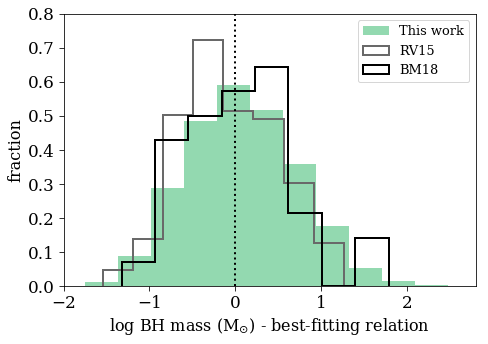

In [15]:
# plot the distribution of residuals around the best-fitting relations

plt.figure(1, figsize = (7, 5))

# with bulge mass measurements
total_stellar_mass_mine = numpy.copy(x_list).astype(numpy.float64)
bh_mass_mine = numpy.copy(y_list).astype(numpy.float64)
delta_bh_mass_mine_with_total_stellar = bh_mass_mine - (a * (total_stellar_mass_mine) + b)

# Reines and Volonteri (2015) dataset
path = "./data/reines_volonteri_m_sigma.fit"
h = fits.open(path)
data_reines = h[1].data
bh_mass_reines = data_reines['logMBH']
bulge_mass_reines = data_reines['logM_']
delta_bh_mass_reines = bh_mass_reines - (7.45 + 1.05 * (bulge_mass_reines - 11))

# Bentz and Manne-Nicholas 2018 dataset
log_bh_mass_bentz = numpy.array([7.23, 8.067, 8.487, 7.57, 7.745, 8.068, 8.102, 7.612, 7.858, 7.292, 6.775, 7.395, 6.558, 6.67, 6.212, 6.13, 7.555, 6.133, 6.822, 8.839, 7.758, 6.882, 6.407, 8.537, 8.537, 8.539, 9.007, 7.586, 8.339, 8.667, 8.786, 8.638, 6.913, 7.038, 7.433, 6.956])
log_bulge_mass_1_bentz = numpy.array([10.17, 10.63, 10.24, 11.25, 10.86, 11.04, 10.68, 10.69, 10.72, 10.68, 11.03, 10.52, 10.38, 10.44, 9.98, 10.13, 10.4, 10.07, 10.18, 11.11, 11.07, 10.83, 10.46, 11.11, 11.07, 11.01, 11.1, 10.97, 11.68, 10.31, 11.23, 10.94, 10.32, 10.34, 11.16, 10.88])
log_bulge_mass_2_bentz = numpy.array([9.78, 10.0, 9.55, 11.01, 10.54, 10.68, 10.31, 10.31, 10.36, 10.47, 10.78, 10.08, 10.05, 10.19, 9.53, 9.56, 10.01, 9.69, 9.7, 10.37, 10.73, 10.4, 10.07, 10.55, 10.86, 10.69, 10.67, 10.63, 11.34, 9.74, 10.69, 10.66, 9.87, 9.85, 10.92, 10.45])
delta_bh_mass_bentz = log_bh_mass_bentz - (1.69 * (log_bulge_mass_1_bentz - 11) + 8.05)

# plot the histograms
tmp = plt.hist(delta_bh_mass_mine_with_bulge, bins=20, color="#28B463", alpha=0.5, normed=1, label="This work")
tmp = plt.hist(delta_bh_mass_reines, bins=8, color="#696969", normed=1, lw=2, histtype='step', fill=False, label="RV15")
tmp = plt.hist(delta_bh_mass_bentz, bins=8, color="k", normed=1, lw=2, histtype='step', fill=False, label="BM18")

plt.vlines([0], 0, 1., linestyles="dotted", lw=2, color="k")
plt.legend(loc="upper right", fontsize=13)
plt.ylabel("fraction", fontsize=16)
plt.xlabel("log BH mass (M$_{\\mathrm{\\odot}}$) - best-fitting relation", fontsize=16)
plt.ylim(0, 0.8)
plt.xlim(-2, 2.8)
plt.tight_layout()

(9.0, 12.1)

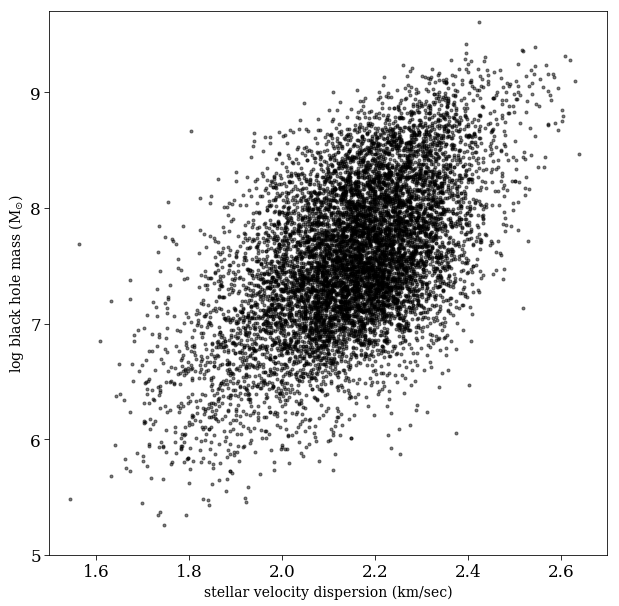

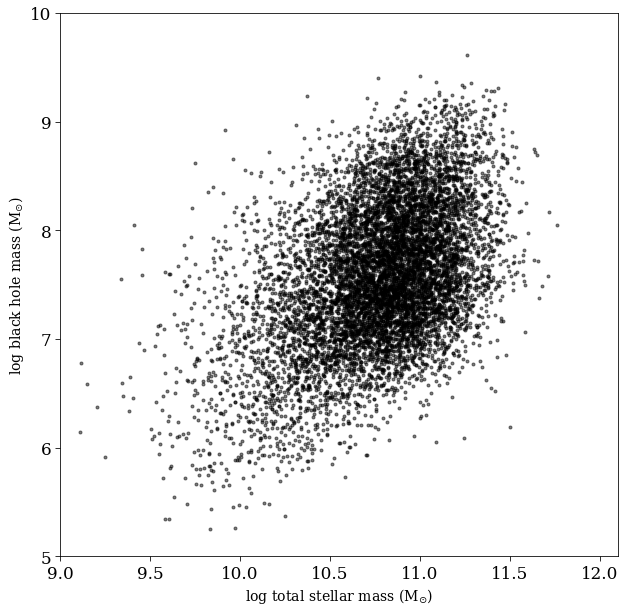

In [40]:
# simple figures without the type I AGN

# first figure - black hole mass versus stellar velocity dispersion
plt.figure(1, figsize = (10, 10))
plt.plot(metadata_typeII['log_stellar_sigma'], metadata_typeII['log_bh_mass'], ".k", alpha=0.5)
plt.xlabel("stellar velocity dispersion (km/sec)")
plt.ylabel("log black hole mass (M$_{\\odot}$)")
plt.xlim(1.5, 2.7)
plt.ylim(5.0, 9.7)

# second figure - black hole mass versus total stellar mass
plt.figure(2, figsize = (10, 10))
plt.plot(metadata_typeII['mendel_logMt_p50'], metadata_typeII['log_bh_mass'], ".k", alpha=0.5)
plt.xlabel("log total stellar mass (M$_{\\odot}$)")
plt.ylabel("log black hole mass (M$_{\\odot}$)")
plt.ylim(5.0, 10)
plt.xlim(9.0, 12.1)

# 2.1 Estimate the BH mass of type II AGN
The next cell shows how to use the python code attached to estimate BH mass of type II AGN, given their narrow emission line fluxes.

In [6]:
import estimate_BH_mass

hbeta_flux_list = numpy.array(metadata_typeII['h_beta_flux']).astype(numpy.float64)
oiii_flux_list = numpy.array(metadata_typeII['oiii_5007_flux']).astype(numpy.float64)
halpha_flux_list = numpy.array(metadata_typeII['h_alpha_flux']).astype(numpy.float64)
z_list = numpy.array(metadata_typeII['z']).astype(numpy.float64)

log_bh_mass_typeII = estimate_BH_mass.return_bh_mass(hbeta_flux_list, halpha_flux_list, oiii_flux_list, z_list)

Text(0, 0.5, 'N')

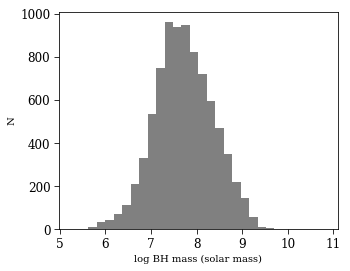

In [7]:
plt.figure(1, figsize=(5, 4))
tmp = plt.hist(log_bh_mass_typeII[~numpy.isnan(log_bh_mass_typeII)], bins=30, color="grey")
plt.xlabel("log BH mass (solar mass)")
plt.ylabel("N")